<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Source-Extractor" data-toc-modified-id="Source-Extractor-1">Source Extractor</a></span></li><li><span><a href="#try-ellipse" data-toc-modified-id="try-ellipse-2">try ellipse</a></span></li></ul></div>

In [7]:
import math, astropy, matplotlib, numpy as np
from astropy.io import ascii, fits

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
%matplotlib inline

In [39]:
hdulist = fits.open('../data/hst_9401_01_acs_wfc_f850lp_drz.fits')
mask = (hdulist[2].data <= 0).astype(float)
mask = np.logical_or(mask, (hdulist[1].data <= 0).astype(float))

import pyregion
region_name = "../data/star_F850.reg"
r = pyregion.open(region_name).as_imagecoord(header=hdulist[0].header).get_mask(shape=hdulist[1].data.shape) 
mask2 = np.logical_or(mask, r).astype(float)

In [41]:
#tem = fits.HDUList(fits.PrimaryHDU(mask))
#tem.writeto('/Users/menggu/WORK/M49/mask_F814W.fits')

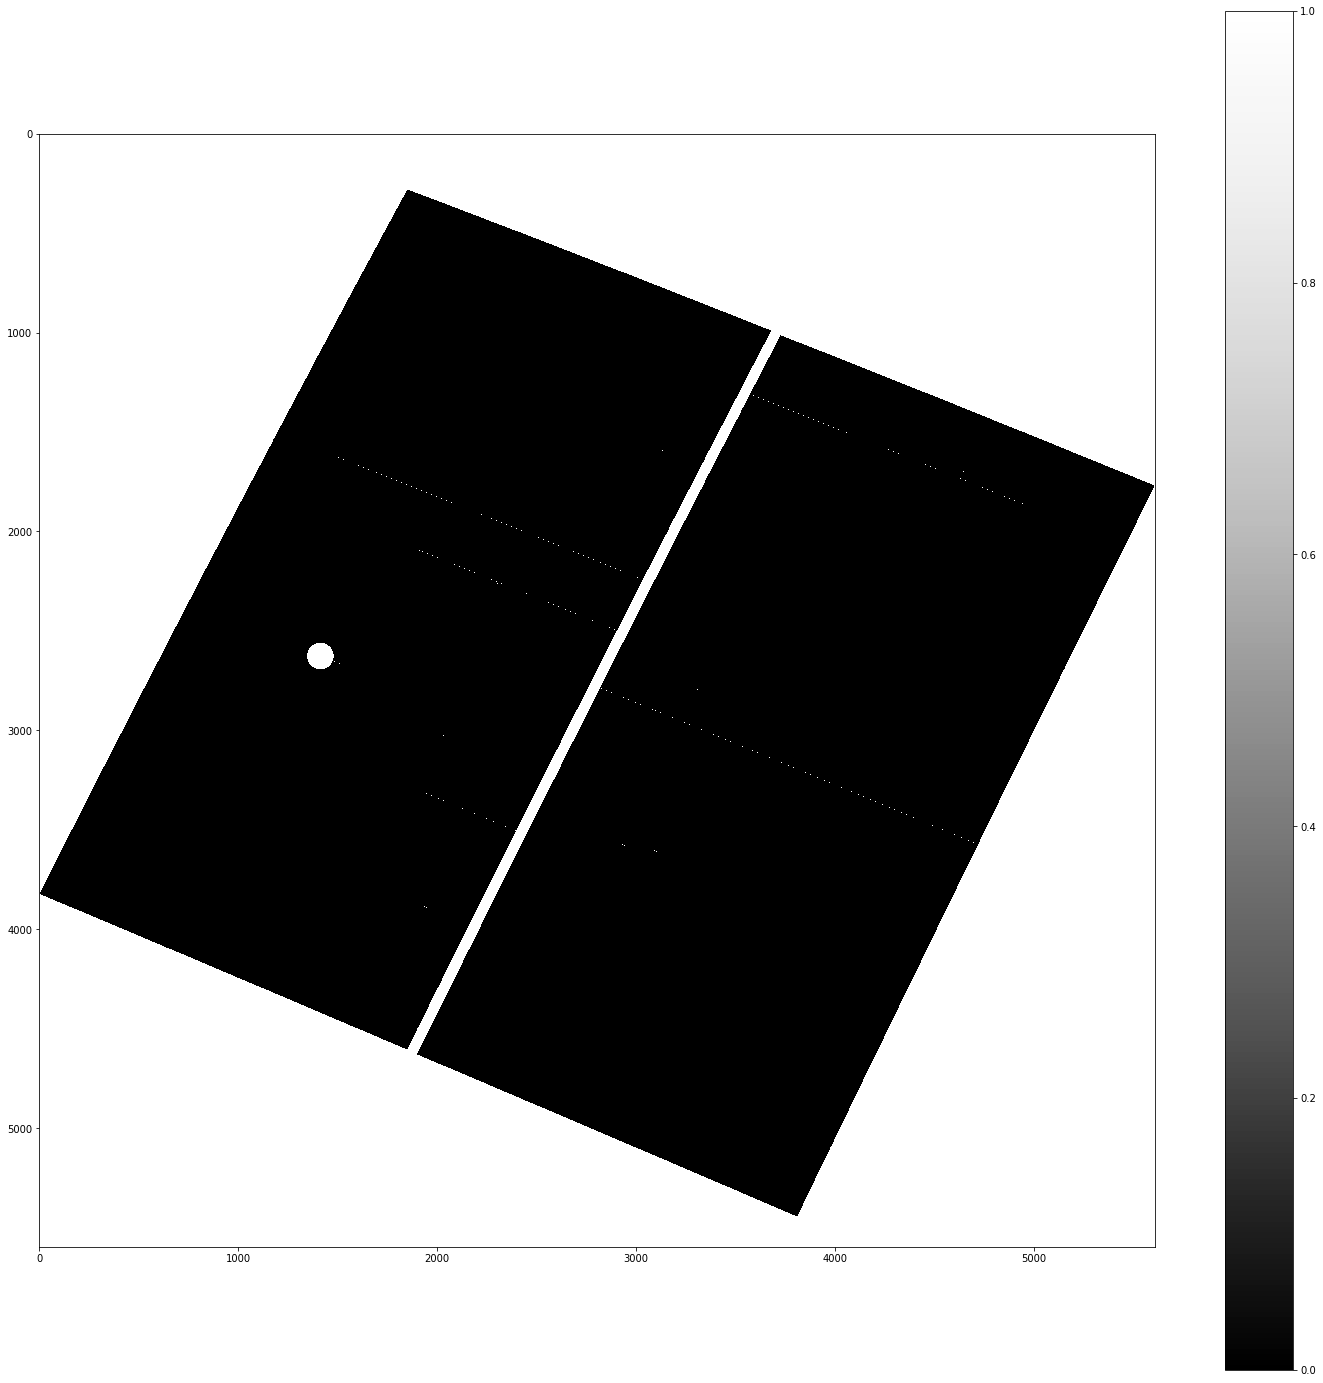

In [42]:
plt.figure(figsize=(25, 25))
plt.imshow(mask2, cmap='Greys_r')
plt.colorbar()

In [14]:
#del tem
#tem = fits.HDUList(fits.PrimaryHDU(hdulist[1].data))
#tem.writeto('/Users/menggu/WORK/M49/data_F814W.fits')

In [7]:
#import pyregion
#import astropy
#from astropy.io import ascii, fits

#region_name = "/Users/menggu/WORK/M49/star_F850.reg"
#r = pyregion.open(region_name).as_imagecoord(header=hdulist[0].header).get_mask(shape=hdulist[1].data.shape) 
#tem_hdulist = fits.HDUList(fits.PrimaryHDU(r*1))
#tem_hdulist.writeto('/Users/menggu/WORK/Muse/data/targets/temmask.fit')

# Source Extractor
https://sep.readthedocs.io/en/v1.0.x/

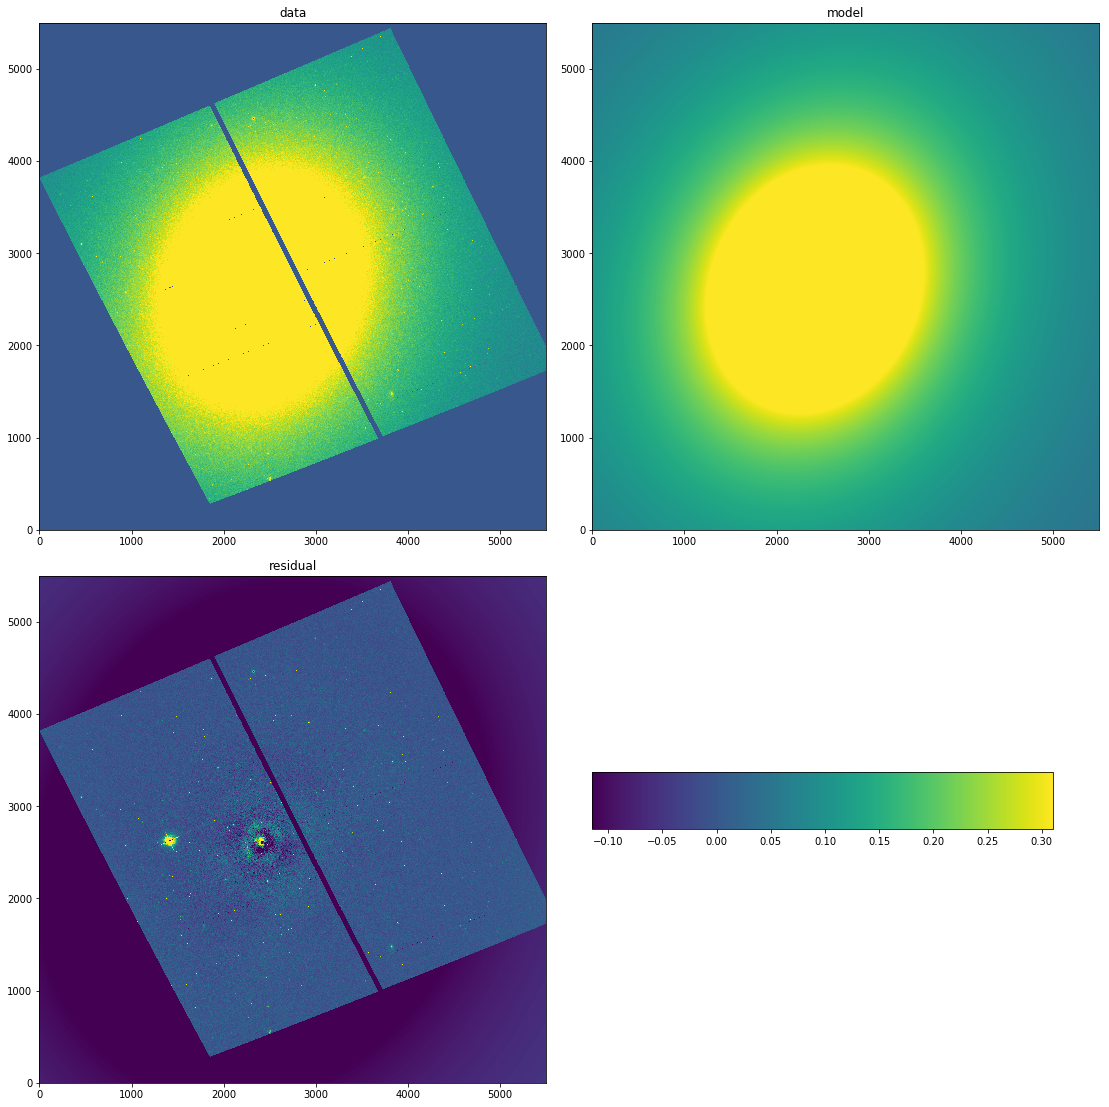

In [8]:
# show data and residual
res = fits.open('../data/imgblock_F850LP.fits')

fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_axes( [0.08, 0.56, 0.44, 0.44]); ax1.set_title('data') 
ax2 = fig.add_axes( [0.56, 0.56, 0.44, 0.44]); ax2.set_title('model') 
ax3 = fig.add_axes( [0.08, 0.08, 0.44, 0.44]); ax3.set_title('residual') 

cax = ax1.imshow(res[1].data, origin='lower',
           vmin = -np.percentile(res[1].data, 50), 
           vmax = np.percentile(res[1].data, 84))


ax2.imshow(res[2].data, origin='lower',
           vmin = -np.percentile(res[1].data, 50), 
           vmax = np.percentile(res[1].data, 84))


ax3.imshow(res[3].data, origin='lower',
           vmin = -np.percentile(res[1].data, 50), 
           vmax = np.percentile(res[1].data, 84))


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.56, 0.3, 0.4, 0.05])
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal')    

background, rms -0.00111168401781 0.0127759426832


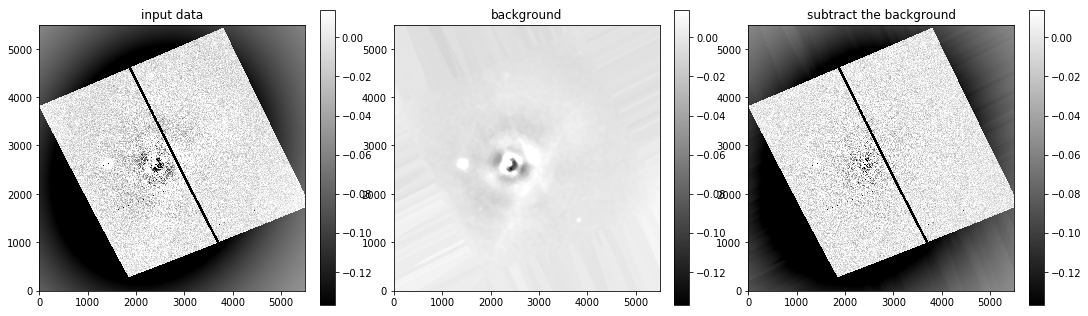

In [9]:
import sep
indata = np.copy(res[3].data)

bkg = sep.Background(indata.byteswap().newbyteorder(), 
                     mask = np.copy(mask[:5500,:5500]), 
                     bw=32, bh=32, fw=3, fh=3)
print 'background, rms', bkg.globalback,  bkg.globalrms

fig = plt.figure(figsize=(18, 9))
plt.subplot(131); plt.title('input data')
plt.imshow(indata, interpolation='nearest', cmap='gray', 
           vmin=np.nanpercentile(indata, 10), 
           vmax=np.nanpercentile(indata, 90), origin='lower')
plt.colorbar(fraction=0.05)


plt.subplot(132); plt.title('background')
bkg_image = bkg.back()
plt.imshow(bkg_image, interpolation='nearest', cmap='gray', 
           vmin=np.nanpercentile(indata, 10), 
           vmax=np.nanpercentile(indata, 90), origin='lower')
plt.colorbar(fraction=0.05)


plt.subplot(133); plt.title('subtract the background')
plt.imshow(indata - bkg, interpolation='nearest', cmap='gray',            
           vmin=np.nanpercentile(indata, 10), 
           vmax=np.nanpercentile(indata, 90), origin='lower') 
plt.colorbar(fraction=0.05)

In [10]:
bkg_rms = bkg.rms()
sep_objects = sep.extract(indata - bkg, 
                          6.5, # the detection threshold
                          deblend_nthresh=32, deblend_cont=0.5,
                          err=bkg.globalrms)
print 'Number of objects detected', len(sep_objects)
sorted_obj = np.sort(sep_objects, order = 'flux')[::-1]

Number of objects detected 1097


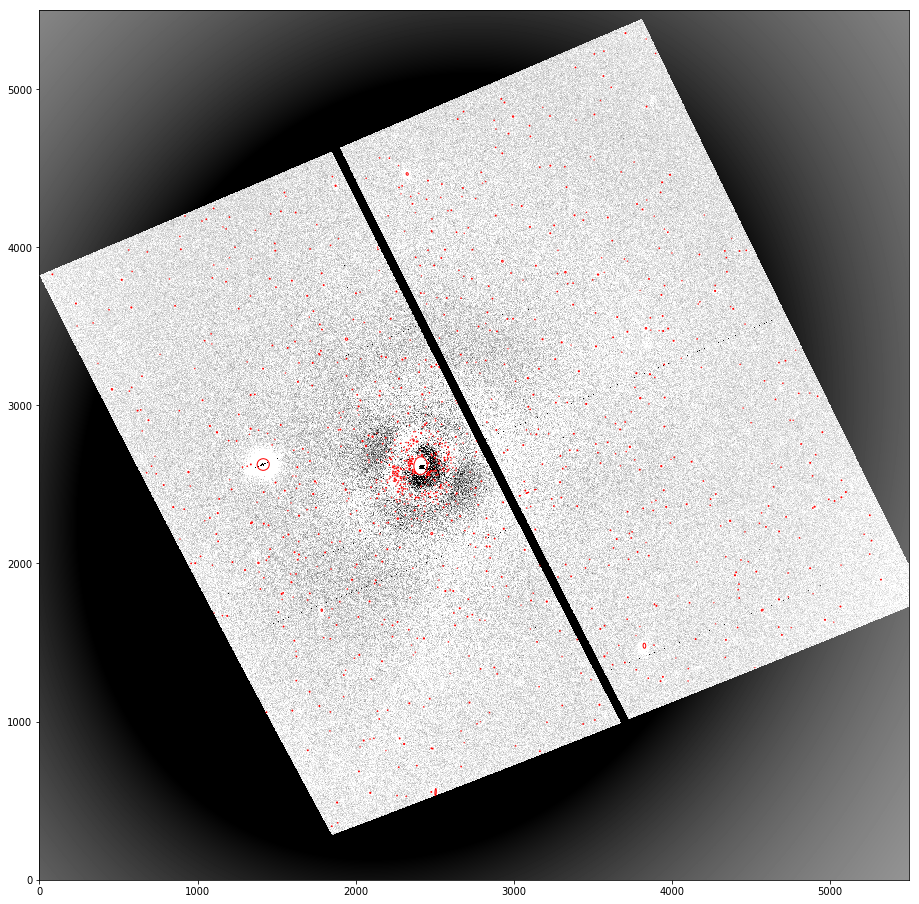

In [11]:
from matplotlib.patches import Ellipse
fig, ax = plt.subplots(figsize=(16, 16))
plt.imshow(indata, interpolation='nearest', origin='lower', cmap='gray', 
           vmin=np.nanpercentile(indata, 10), 
           vmax=np.nanpercentile(indata, 90))

for i in xrange(len(sorted_obj)): 
    e = Ellipse(xy=(sorted_obj['x'][i], sorted_obj['y'][i]),
                width = 4*sorted_obj['a'][i],  
                height = 4*sorted_obj['b'][i],  
                angle = sorted_obj['theta'][i] * 180. / np.pi)

    e.set_facecolor('none'); e.set_edgecolor('r'); e.set_lw(1)
    ax.add_artist(e)

In [13]:
from astropy.table import Table

print('remember in ds9 use (x+1, y+1)')
loclist = {}
loclist['x'] = np.round( np.copy(sorted_obj['x']+1), 2)
loclist['y'] = np.round( np.copy(sorted_obj['y']+1) , 2)  
t = Table(loclist, names=('x', 'y'))
print t
t.write('sepobj_F850LP.reg', format='ascii.no_header')

remember in ds9 use (x+1, y+1)
   x       y   
------- -------
1416.22 2626.54
2411.51 2618.85
2326.68 4463.99
2506.45  555.03
1873.98 4389.39
2482.06 2190.15
2928.73 3912.26
4273.75 3724.22
 459.92 3102.03
2107.64  2802.7
    ...     ...
1329.81 2816.79
2444.96  2992.0
2633.61 3030.21
2332.99 2380.03
1203.81 2530.61
 2095.2 2412.39
2637.62 2754.19
 2012.8  2970.6
1513.39 2414.21
2287.22 4338.41
2658.39  2855.6
Length = 1097 rows


# try ellipse
http://photutils.readthedocs.io/en/stable/isophote.html

CPU times: user 710 ms, sys: 212 ms, total: 922 ms
Wall time: 933 ms


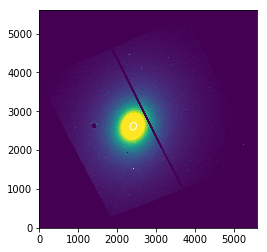

In [52]:
%%time
data = np.copy(hdulist[1].data)
data[mask2>=1] = 0

from photutils.isophote import EllipseGeometry
import matplotlib.pyplot as plt
from photutils import EllipticalAperture
from photutils.isophote import build_ellipse_model


geometry = EllipseGeometry(x0=2419.29, y0=2615.35, sma=100, eps=0.2,
                            pa=72.*np.pi/180.)


aper = EllipticalAperture((geometry.x0, geometry.y0), geometry.sma,
                            geometry.sma*(1 - geometry.eps),
                            geometry.pa)
plt.imshow(data, origin='lower', 
           vmin = np.nanpercentile(data, 50), 
           vmax = np.nanpercentile(data, 99))
aper.plot(color='white')

In [59]:
%%time
from photutils.isophote import Ellipse
ellipse = Ellipse(data, geometry)
isolist = ellipse.fit_image(minsma=4, maxsma=2200, sma0=200)
#isolist = pickle.load(open("isolist_F850LP.p", 'rb'))

CPU times: user 38.9 s, sys: 5.73 s, total: 44.7 s
Wall time: 45.8 s


In [60]:
len(isolist)

67

In [61]:
isolist

In [62]:
#isolist.to_table().write('ellipse_F850LP.dat', format='ascii')
#data.shape

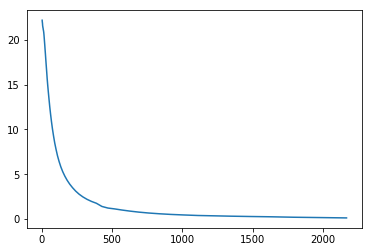

In [63]:
plt.plot(isolist.sma, f[0[isolist.intens)

In [53]:
#import pickle
#pickle.dumps(isolist, open("isolist_F850LP.p", 'wb'))
model_image = build_ellipse_model(data.shape, isolist)  
#pickle.dumps(model_image, open("model_image_F850LP.p", 'wb'))
#model_image = pickle.load(open("model_image_F850LP.p", 'rb'))
residual = data - model_image

KeyboardInterrupt: 

In [ ]:
# show data and residual
fig = plt.figure(figsize=(16, 16))
ax1 = fig.add_axes( [0.08, 0.56, 0.44, 0.44]); ax1.set_title('data') 
ax2 = fig.add_axes( [0.56, 0.56, 0.44, 0.44]); ax2.set_title('model') 
ax3 = fig.add_axes( [0.08, 0.08, 0.44, 0.44]); ax3.set_title('residual') 

cax = ax1.imshow(data, origin='lower',
           vmin = np.percentile(data, 16), 
           vmax = np.percentile(data, 84))


ax2.imshow(model_image, origin='lower',
           vmin = np.percentile(data, 16), 
           vmax = np.percentile(data, 84))


ax3.imshow(residual, origin='lower',
           vmin = np.percentile(data, 16), 
           vmax = np.percentile(data, 84))


fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.56, 0.3, 0.4, 0.05])
cbar = fig.colorbar(cax, cax=cbar_ax, orientation='horizontal')    